# NLP Prediction Model - Yelp Reviews

### Overview
0. Features selected for DataFrame in previous notebook - Yelp-NLP-Preprocessing 
1. Perform EDA on classified Yelp data of reviews and businesses - target variable whether business is open
1. Predict whether business is open based off reviews, and focus on false positives, indicated a business may be susceptible to closing
1. Separate notebooks for determining themes amongst the businesses falling under false positives

In [1]:
#basic packages
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import hstack, csr_matrix
import numpy as np
import re
import pickle

#NLP pre-processing packages
import nltk 
import re
from nltk import WordNetLemmatizer, pos_tag # lemmatizer using WordNet, nltk's native part of speech tagging
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords, wordnet # imports WordNet and stopwords
#unhash below if not installed
#nltk.download('stopwords')

#packages from class creation exercise
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import GridSearchCV

#model packages
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from keras.preprocessing.text import Tokenizer #used for analysis, but in general is a legacy package

#model packages
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix, ConfusionMatrixDisplay,RocCurveDisplay,roc_auc_score
from sklearn.metrics import plot_roc_curve

### EDA on Yelp Dataset:

In [5]:
df = pd.read_csv('../test_yelp.csv')
df.head()

,text,review_rating,business_rating_avg,review_count,is_open
0,Great breakfast. Cute location and generally j...,4.0,4.0,642,1
1,I totally agree with Edward D. My kids and I w...,1.0,4.0,93,1
2,Super amazing food top notch. Best lobster rol...,5.0,3.0,76,1
3,"Cook with your heart, think with your head, pl...",2.0,4.5,819,1
4,SAB Cafe is right in the thick of the downtown...,4.0,4.0,199,1


In [6]:
df['is_open'].value_counts()

1    1199046
0    1199046
Name: is_open, dtype: int64

In [7]:
df.corr()

,review_rating,business_rating_avg,review_count,is_open
review_rating,1.000000,0.484387,0.075113,0.052166
business_rating_avg,0.484387,1.000000,0.145972,0.106196
review_count,0.075113,0.145972,1.000000,0.199750
is_open,0.052166,0.106196,0.199750,1.000000


In [8]:
#creating a sample dataframe to test preprocessing classes and functions before feeding in entire dataset
samp_df = df.sample(frac=1.0).head(100)
samp_df['is_open'].value_counts()

0    57
1    43
Name: is_open, dtype: int64

### Class creation for future tweet cleaning:

1. Lemmatizing class provided by Flatiron lecture - fine-tuned for this dataset
1. Stemming class to be tweaked based off lemmatizing base Class

In [9]:
#create a class to stem the texts - given large dataset, faster compared to lemmatizing
#FOR FUTURE: move variables that are hashed into __init__ function
class TextPreprocessorSTEM(BaseEstimator, TransformerMixin):
    def __init__(self):  #, language='english'):
        #self.stemmer = SnowballStemmer(language)
        #self.stop_words = set(stopwords.words(language))
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
        
        # save as parameters of Text preprocessor
        
        return self        
        
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        return fully_normalized_corpus
       
    def process_doc(self, doc):
        stop_words = set(stopwords.words('english'))
        stemmer = SnowballStemmer('english')
        text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
        # Tokenize the text
        doc = re.sub(text_cleaning_re, ' ', str(doc).lower()).strip()
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words)) ]    
        # Apply stemming using Snowball Stemmer
        stemmed_words = [stemmer.stem(word) for word in doc_norm if word not in stop_words]
        return " ".join(stemmed_words)

In [6]:
#baseline class that lemmatizes text
class TextPreprocessorLEM(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
        
        # save as parameters of Text preprocessor
        
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None

        #text cleaning with re:
        text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
        #"@\S+" : Matches one or more non-whitespace characters after "@".
        #"https?:\S+|http?:\S:" This part of the pattern matches URLs starting with "http" or "https".
        #[^A-Za-z0-9]+: This part of the pattern matches any non-alphanumeric character.    
                   
        #remove URL's and tagged users (using the @ symbol), lower-cases the text, and gets rid of all spaces
        doc = re.sub(text_cleaning_re, ' ', str(doc).lower()).strip()
        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words)) ]
        
        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [7]:
#saving the function for future use
proc_stem = TextPreprocessorSTEM()
proc_lem = TextPreprocessorLEM()

# Serialize the class object and save it to a file
with open('TextPreprocessorSTEM.pkl', 'wb') as file_stem:
    pickle.dump(proc_stem, file_stem)
    
with open('TextPreprocessorLEM.pkl', 'wb') as file_lem:
    pickle.dump(proc_lem, file_lem)

In [8]:
proc_stem = TextPreprocessorSTEM()
with open('TextPreprocessorSTEM.pkl', 'wb') as file_stem:
    pickle.dump(proc_stem, file_stem)

In [9]:
#Checking the class performance on the sample dataframe
X = samp_df['text']
proc_stem = TextPreprocessorSTEM()
proc_lem = TextPreprocessorLEM()
transformed_X_stem = proc_stem.fit_transform(X) 
transformed_X_lem = proc_lem.fit_transform(X) 

In [10]:
transformed_X_stem

591267     got stay one night say everyth experi perfect ...
1805446    disappoint experi wife went lunch date birthda...
1795994          great diner great valu wonder servic danica
1542021    best flea market lot cloth bling shop nsw equi...
1360211    food excel fresh could share lunch portion stu...
                                 ...                        
277888     realli want like place love bowl locat great p...
187396     place serious awesom indian food authent mani ...
1178525    parent hype restaur week rave food week unsati...
996227     use pep boy delawar ave year first period year...
33371      place worth hype see differ advertis feed vent...
Name: text, Length: 100, dtype: object

In [11]:
transformed_X_lem


591267     get stay night say everything experience perfe...
1805446    disappointing experience wife go lunch date bi...
1795994     great diner great value wonderful service danica
1542021    best flea market lot clothes bling shop nsw eq...
1360211    food excellent fresh share lunch portion stuff...
                                 ...                        
277888     really want place love bowl location great pri...
187396     place seriously awesome indian food authentic ...
1178525    parent hype restaurant week rave food week uns...
996227     use pep boy delaware ave year first period yea...
33371      place worth hype see different advertisement f...
Name: text, Length: 100, dtype: object

#### Conclusion on pre-processing class:

It appears to be working ok on the sample data to get the data in the right format

### Pre-processing the data

In [10]:
#holdout test set for final evaluation - ensure no data leakage throughout iterative model process
features = df.drop('is_open', axis=1)
target = df['is_open']
other_cols = ['review_rating', 'business_rating_avg', 'review_count']

X, X_test, y, y_test = train_test_split(features, target, test_size = 0.2, random_state = 53)

train_df = pd.DataFrame(data=X)
train_df['is_open'] = y

In [13]:
#train_df

In [14]:
samp_df1 = train_df.sample(frac=1.0).head(1000)
samp_df1['is_open'].value_counts()

1    528
0    472
Name: is_open, dtype: int64

In [15]:
#perform the train-test split 
X1 = samp_df1.drop('is_open', axis=1)
y1 = samp_df1['is_open']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 53)

print("Train Data size:", len(X_train1))
print("Test Data size", len(X_test1))

Train Data size: 800
Test Data size 200


In [16]:
#preprocess X_train with the two classes
#create instances of all processors:
proc_stem = TextPreprocessorSTEM()
proc_lem = TextPreprocessorLEM()

#create dataframes with Stemmed data
X_train_stem1 = proc_stem.fit_transform(X_train1['text'])
test_stem1 = proc_stem.transform(X_test1['text'])

#create dataframes with lemmed data
X_train_lem1 = proc_lem.fit_transform(X_train1['text']) 
test_lem1 = proc_lem.transform(X_test1['text'])

### Preparing the different models and parameters using GridSearchCV:

Text preprocessing methods:
1. Stemming (snowball) - done in preprocessing
1. Lemmatizing (using WordNetLem) - done in preprocessing

Vectorizers:
1. Count Vectorizer
1. Tf-Idf Vectorizers

Models to run:
1. Logistic Regression
1. Simple Decision Tree Classifier
1. Random Forest classifier
1. Multinomial Naive Bayes
1. Gradient-boosted Trees

Pipelines to run:
1. full GridSearchCV on sample of dataset (`n=1,000`)
1. determine best combinations (`n=?`), and run second round of GridSearchCV by top `n` models with larger sample (`n=10,000`)
1. narrow down best combinations to feed into third iteration of sample size (`n=100,000`)
1. best combination of above to feed entire dataset into

In [15]:
vectorizer1_1a = CountVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1, 10))
X_1_1a = vectorizer1_1a.fit_transform(X_train_stem1)
X_1_1a = pd.DataFrame.sparse.from_spmatrix(X_1_1a)
X_1_1a = pd.concat([X_train1[other_cols].reset_index(drop=True), X_1_1a], axis=1)
X_1_1a.shape

(800, 997)

In [16]:
vectorizer1_1b = TfidfVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1, 10))
X_1_1b = vectorizer1_1b.fit_transform(X_train_stem1)
X_1_1b = pd.DataFrame.sparse.from_spmatrix(X_1_1b)
X_1_1b = pd.concat([X_train1[other_cols].reset_index(drop=True), X_1_1b], axis=1)
X_1_1b.shape

(800, 997)

In [17]:
vectorizer1_2a = CountVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1, 10))
X_1_2a = vectorizer1_2a.fit_transform(X_train_lem1)
X_1_2a = pd.DataFrame.sparse.from_spmatrix(X_1_2a)
X_1_2a = pd.concat([X_train1[other_cols].reset_index(drop=True), X_1_2a], axis=1)
X_1_2a.shape

(800, 930)

In [18]:
vectorizer1_2b = TfidfVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1, 10))
X_1_2b = vectorizer1_2b.fit_transform(X_train_lem1)
X_1_2b = pd.DataFrame.sparse.from_spmatrix(X_1_2b)
X_1_2b = pd.concat([X_train1[other_cols].reset_index(drop=True), X_1_2b], axis=1)
X_1_2b.shape

(800, 930)

In [24]:
#vectorizer dictionary
#vectorizers = {
#    'tfidf': TfidfVectorizer(),
#    'count': CountVectorizer()
#}

#Models and respective hyper-parameters
rs=53 #random state the same across models
# Initialze the estimators
clf1 = LogisticRegression(random_state=rs)
clf2 = DecisionTreeClassifier(random_state=rs)
clf3 = RandomForestClassifier(random_state=rs)
clf4 = MultinomialNB()
clf5 = GradientBoostingClassifier(random_state=rs)

# Initiaze the hyperparameters for each dictionary
param1 = {}
#param1['vectorizer'] = list(vectorizers.values())
#param1['vectorizer__ngram_range'] = [(1, 1), (1, 4)]
param1['classifier'] = [clf1]
param1['classifier__C'] = [.01, .1, 1, 10, 100]
param1['classifier__penalty'] = ['l2']#, 'l1'], if we want to include lasso

param2 = {}
#param2['vectorizer'] = list(vectorizers.values())
#param2['vectorizer__ngram_range'] = [(1, 1), (1, 4)]
param2['classifier'] = [clf2]
param2['classifier__max_depth'] = [5,10]
param2['classifier__min_samples_split'] = [2,5,10]
#param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]

param3 = {}
#param3['vectorizer'] = list(vectorizers.values())
#param3['vectorizer__ngram_range'] = [(1, 1), (1, 4)]
param3['classifier'] = [clf3]
param3['classifier__n_estimators'] = [10, 50, 100, 250]
param3['classifier__max_depth'] = [5, 10]
#param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]

param4 = {}
#param4['vectorizer'] = list(vectorizers.values())
#param4['vectorizer__ngram_range'] = [(1, 1), (1, 4)]
param4['classifier'] = [clf4]
param4['classifier__alpha'] = [0.1, 0.5, 1]

param5 = {}
#param5['vectorizer'] = list(vectorizers.values())
#param5['vectorizer__ngram_range'] = [(1, 1), (1, 4)]
param5['classifier'] = [clf5]
param5['classifier__n_estimators'] = [10, 50, 100, 250]
param5['classifier__max_depth'] = [5, 10, 20]


In [25]:
#create pipeline for non-tuned models
pipeline1 = Pipeline([
 #   ('vectorizer', None),
    ('classifier', None)
])

params = [param1, param2, param3, param4, param5]

In [26]:
# GridSearchCV objects for each set of preprocessed data
grid_search1_stem_a = GridSearchCV(pipeline1, 
                           params, 
                           scoring = 'accuracy',
                           cv=3)
grid_search1_stem_b = GridSearchCV(pipeline1, 
                           params, 
                           scoring = 'accuracy',
                           cv=3)

grid_search1_lem_a = GridSearchCV(pipeline1, 
                           params, 
                           scoring = 'accuracy',
                           cv=3)

grid_search1_lem_b = GridSearchCV(pipeline1, 
                           params, 
                           scoring = 'accuracy',
                           cv=3)

#### Evaluation of best model with standard parameters

In [27]:
grid_search1_stem_a.fit(X_1_1a, y_train1)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\lea

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reid Majka\anaconda3\envs\lea

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

GridSearchCV(cv=3, estimator=Pipeline(steps=[('classifier', None)]),
             param_grid=[{'classifier': [LogisticRegression(random_state=53)],
                          'classifier__C': [0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2']},
                         {'classifier': [DecisionTreeClassifier(random_state=53)],
                          'classifier__max_depth': [5, 10],
                          'classifier__min_samples_split': [2, 5, 10]},
                         {'classifier': [RandomFore...ier(random_state=53)],
                          'classifier__max_depth': [5, 10],
                          'classifier__n_estimators': [10, 50, 100, 250]},
                         {'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.1, 0.5, 1]},
                         {'classifier': [GradientBoostingClassifier(max_depth=10,
                                                                    n_estimators=250,
         

In [28]:
grid_search1_stem_b.fit(X_1_1b, y_train1)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\lea

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

GridSearchCV(cv=3, estimator=Pipeline(steps=[('classifier', None)]),
             param_grid=[{'classifier': [LogisticRegression(random_state=53)],
                          'classifier__C': [0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2']},
                         {'classifier': [DecisionTreeClassifier(random_state=53)],
                          'classifier__max_depth': [5, 10],
                          'classifier__min_samples_split': [2, 5, 10]},
                         {'classifier': [RandomFore...
                                                                n_estimators=250,
                                                                random_state=53)],
                          'classifier__max_depth': [5, 10],
                          'classifier__n_estimators': [10, 50, 100, 250]},
                         {'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.1, 0.5, 1]},
                         {'classif

In [29]:
grid_search1_lem_a.fit(X_1_2a, y_train1)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\lea

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\lea

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

GridSearchCV(cv=3, estimator=Pipeline(steps=[('classifier', None)]),
             param_grid=[{'classifier': [LogisticRegression(random_state=53)],
                          'classifier__C': [0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2']},
                         {'classifier': [DecisionTreeClassifier(random_state=53)],
                          'classifier__max_depth': [5, 10],
                          'classifier__min_samples_split': [2, 5, 10]},
                         {'classifier': [RandomFore...=10,
                                                                n_estimators=250,
                                                                random_state=53)],
                          'classifier__max_depth': [5, 10],
                          'classifier__n_estimators': [10, 50, 100, 250]},
                         {'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.1, 0.5, 1]},
                         {'cla

In [ ]:
grid_search1_lem_b.fit(X_1_2b, y_train1)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\lea

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse column

In [ ]:
#create Dataframe of results from stem and lem
grid_search1_stem_df1 = pd.DataFrame(grid_search1_stem_a.cv_results_)
grid_search1_stem_df2 = pd.DataFrame(grid_search1_stem_b.cv_results_)
grid_search1_lem_df1 = pd.DataFrame(grid_search1_lem_a.cv_results_)
grid_search1_lem_df2 = pd.DataFrame(grid_search1_lem_b.cv_results_)

grid_search1_stem_df1['preprocessor'] = 'TextPreprocessorSTEM()'
grid_search1_stem_df2['preprocessor'] = 'TextPreprocessorSTEM()'
grid_search1_lem_df1['preprocessor'] = 'TextPreprocessorLEM()'
grid_search1_lem_df2['preprocessor'] = 'TextPreprocessorLEM()'

grid_search1_stem_df1['vectorizer'] = 'Count'
grid_search1_stem_df2['vectorizer'] = 'Tf-Idf'
grid_search1_lem_df1['vectorizer'] = 'Count'
grid_search1_lem_df2['vectorizer'] = 'Tf-Idf'

grid_search1_df = pd.concat([grid_search1_lem_df1, grid_search1_lem_df2, grid_search1_stem_df1, grid_search1_stem_df2], axis=0, ignore_index=True)
grid_search1_df.head()

In [68]:
grid_search1_df.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,1.606917,0.179857,0.052820,0.005988,0.579588,0.552930,0.578422,0.570313,0.021815,17.441176
std,2.790095,0.522450,0.014035,0.006673,0.029167,0.033619,0.033784,0.023951,0.011839,9.765976
min,0.266787,0.000033,0.031336,0.000004,0.483146,0.483146,0.492481,0.512503,0.001535,1.000000
25%,0.343674,0.007880,0.045734,0.000985,0.565543,0.524345,0.555451,0.555308,0.012273,9.000000
50%,0.450981,0.022223,0.047390,0.005333,0.580524,0.544944,0.580827,0.571858,0.020007,17.500000
75%,1.106938,0.107449,0.056671,0.007347,0.599251,0.580524,0.601504,0.582531,0.031025,26.000000
max,16.719722,4.220048,0.115906,0.038609,0.636704,0.625468,0.676692,0.628805,0.050476,34.000000


In [69]:
grid_search1_df = grid_search1_df.sort_values(by='mean_test_score', ascending=False).head(40)

In [70]:
grid_search1_df['param_classifier'].value_counts()

GradientBoostingClassifier(max_depth=10, random_state=53)    18
LogisticRegression(C=1, random_state=53)                     15
RandomForestClassifier(random_state=53)                       4
MultinomialNB()                                               2
DecisionTreeClassifier(random_state=53)                       1
Name: param_classifier, dtype: int64

In [71]:
grid_search1_df['preprocessor'].value_counts()

TextPreprocessorSTEM()    25
TextPreprocessorLEM()     15
Name: preprocessor, dtype: int64

In [72]:
grid_search1_df['vectorizer'].value_counts()

Count     21
Tf-Idf    19
Name: vectorizer, dtype: int64

### Run the Pipeline again with a slightly higher sample size, to see if rankings of GridSearchCV have changed

In [73]:
#slightly higher sample size
samp_df2 = train_df.sample(frac=1.0).head(10000)
samp_df2['is_open'].value_counts()

0    5049
1    4951
Name: is_open, dtype: int64

In [74]:
#perform the train-test split 
X2 = samp_df2.drop('is_open', axis=1)
y2 = samp_df2['is_open']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 53)

In [75]:
pipeline2 = Pipeline([('classifier', None)])
#grid_search2_lem_a = None

In [79]:
# GridSearchCV objects for each set of preprocessed data
params2 = [param5, param1] #choosing top 2 models from above gridsearch for efficiency
grid_search2_stem_a = GridSearchCV(pipeline2, params2, scoring = 'accuracy', cv=3)
grid_search2_stem_b = GridSearchCV(pipeline2, params2, scoring = 'accuracy', cv=3)
grid_search2_lem_a = GridSearchCV(pipeline2, params2, scoring = 'accuracy', cv=3)
grid_search2_lem_b = GridSearchCV(pipeline2, params2, scoring = 'accuracy', cv=3)

In [85]:
#preprocess X_train with the two classes
#create instances of all processors:
proc_stem2 = TextPreprocessorSTEM()
proc_lem2 = TextPreprocessorLEM()

#create dataframes with Stemmed data
X_train_stem2 = proc_stem2.fit_transform(X_train2['text'])
test_stem2 = proc_stem2.transform(X_test2['text'])

#create dataframes with lemmed data
X_train_lem2 = proc_lem2.fit_transform(X_train2['text']) 
test_lem2 = proc_lem2.transform(X_test2['text'])

In [86]:
X_train_stem2

357672     kinda pricey overal clean well maintain locat ...
336860     amaz freshest seafood simpli best wasabi plane...
419032     friend go bauhaus quit time occasion go staff ...
1620969    new name feast recent owner noth chang great f...
1728626    compact spa gym avail local well guest hotel t...
                                 ...                        
388886     dinner twice drink unfortun disappoint time dr...
693475     second time month order deliveri disappoint de...
2261422    still one favorit place nice famili environ fo...
408966     tini mighti wine bar one favorit date night sp...
1807300    visit tampa weekend friend decid tri streetcar...
Name: text, Length: 8000, dtype: object

In [105]:
vectorizer2_1a = CountVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1, 5))
X_2_1a = vectorizer2_1a.fit_transform(X_train_stem2)
X_2_1a = pd.DataFrame.sparse.from_spmatrix(X_2_1a)
X_2_1a = pd.concat([X_train2[other_cols].reset_index(drop=True), X_2_1a], axis=1)
X_2_1a = csr_matrix(X_2_1a.values)

X_2_1a.shape

(8000, 902)

In [106]:
vectorizer2_1b = TfidfVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1, 5))
X_2_1b = vectorizer2_1b.fit_transform(X_train_stem2)
X_2_1b = pd.DataFrame.sparse.from_spmatrix(X_2_1b)
X_2_1b = pd.concat([X_train2[other_cols].reset_index(drop=True), X_2_1b], axis=1)
X_2_1b = csr_matrix(X_2_1b.values)

X_2_1b.shape

(8000, 902)

In [107]:
vectorizer2_2a = CountVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1, 5))
X_2_2a = vectorizer2_2a.fit_transform(X_train_lem2)
X_2_2a = pd.DataFrame.sparse.from_spmatrix(X_2_2a)
X_2_2a = pd.concat([X_train2[other_cols].reset_index(drop=True), X_2_2a], axis=1)
X_2_2a = csr_matrix(X_2_2a.values)

X_2_2a.shape

(8000, 841)

In [108]:
vectorizer2_2b = TfidfVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1, 5))
X_2_2b = vectorizer2_2b.fit_transform(X_train_lem2)
X_2_2b = pd.DataFrame.sparse.from_spmatrix(X_2_2b)
X_2_2b = pd.concat([X_train2[other_cols].reset_index(drop=True), X_2_2b], axis=1)
X_2_2b = csr_matrix(X_2_2b.values)
X_2_2b.shape

(8000, 841)

In [109]:
grid_search2_stem_a.fit(X_2_1a, y_train2)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

GridSearchCV(cv=3, estimator=Pipeline(steps=[('classifier', None)]),
             param_grid=[{'classifier': [GradientBoostingClassifier(max_depth=5,
                                                                    n_estimators=250,
                                                                    random_state=53)],
                          'classifier__max_depth': [5, 10, 20],
                          'classifier__n_estimators': [10, 50, 100, 250]},
                         {'classifier': [LogisticRegression(C=1,
                                                            random_state=53)],
                          'classifier__C': [0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2']}],
             scoring='accuracy')

In [110]:
grid_search2_stem_b.fit(X_2_1b, y_train2)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

GridSearchCV(cv=3, estimator=Pipeline(steps=[('classifier', None)]),
             param_grid=[{'classifier': [GradientBoostingClassifier(max_depth=5,
                                                                    n_estimators=250,
                                                                    random_state=53)],
                          'classifier__max_depth': [5, 10, 20],
                          'classifier__n_estimators': [10, 50, 100, 250]},
                         {'classifier': [LogisticRegression(C=0.1,
                                                            random_state=53)],
                          'classifier__C': [0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2']}],
             scoring='accuracy')

In [111]:
# Run the grid search
grid_search2_lem_a.fit(X_2_2a, y_train2)


C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

GridSearchCV(cv=3, estimator=Pipeline(steps=[('classifier', None)]),
             param_grid=[{'classifier': [GradientBoostingClassifier(max_depth=10,
                                                                    n_estimators=50,
                                                                    random_state=53)],
                          'classifier__max_depth': [5, 10, 20],
                          'classifier__n_estimators': [10, 50, 100, 250]},
                         {'classifier': [LogisticRegression(C=0.1,
                                                            random_state=53)],
                          'classifier__C': [0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2']}],
             scoring='accuracy')

In [112]:
# Run the grid search
grid_search2_lem_b.fit(X_2_2b, y_train2)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

GridSearchCV(cv=3, estimator=Pipeline(steps=[('classifier', None)]),
             param_grid=[{'classifier': [GradientBoostingClassifier(max_depth=10,
                                                                    n_estimators=50,
                                                                    random_state=53)],
                          'classifier__max_depth': [5, 10, 20],
                          'classifier__n_estimators': [10, 50, 100, 250]},
                         {'classifier': [LogisticRegression(C=0.1,
                                                            random_state=53)],
                          'classifier__C': [0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2']}],
             scoring='accuracy')

In [113]:
#create Dataframe of results from stem and lem
grid_search2_stem_df1 = pd.DataFrame(grid_search2_stem_a.cv_results_)
grid_search2_stem_df2 = pd.DataFrame(grid_search2_stem_b.cv_results_)
grid_search2_lem_df1 = pd.DataFrame(grid_search2_lem_a.cv_results_)
grid_search2_lem_df2 = pd.DataFrame(grid_search2_lem_b.cv_results_)

grid_search2_stem_df1['preprocessor'] = 'TextPreprocessorSTEM()'
grid_search2_stem_df2['preprocessor'] = 'TextPreprocessorSTEM()'
grid_search2_lem_df1['preprocessor'] = 'TextPreprocessorLEM()'
grid_search2_lem_df2['preprocessor'] = 'TextPreprocessorLEM()'

grid_search2_stem_df1['vectorizer'] = 'Count'
grid_search2_stem_df2['vectorizer'] = 'Tf-Idf'
grid_search2_lem_df1['vectorizer'] = 'Count'
grid_search2_lem_df2['vectorizer'] = 'Tf-Idf'

grid_search2_df = pd.concat([grid_search1_lem_df1, grid_search1_lem_df2, grid_search1_stem_df1, grid_search1_stem_df2], axis=0, ignore_index=True)
grid_search2_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__max_depth,param_classifier__min_samples_split,param_classifier__n_estimators,param_classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,preprocessor,vectorizer
0,0.362924,0.013806,0.044625,0.012170,"LogisticRegression(C=0.1, random_state=53)",0.01,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.625468,0.606742,0.601504,0.611238,0.010287,2,TextPreprocessorLEM(),Count
1,0.351466,0.006692,0.043023,0.006147,"LogisticRegression(C=0.1, random_state=53)",0.1,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.636704,0.610487,0.609023,0.618738,0.012718,1,TextPreprocessorLEM(),Count
2,0.354373,0.016130,0.045064,0.006104,"LogisticRegression(C=0.1, random_state=53)",1,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.621723,0.588015,0.567669,0.592469,0.022291,5,TextPreprocessorLEM(),Count
3,0.353977,0.006639,0.046343,0.000741,"LogisticRegression(C=0.1, random_state=53)",10,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.617978,0.621723,0.582707,0.607469,0.017576,3,TextPreprocessorLEM(),Count
4,0.346576,0.006488,0.045239,0.002328,"LogisticRegression(C=0.1, random_state=53)",100,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.591760,0.584270,0.560150,0.578727,0.013487,15,TextPreprocessorLEM(),Count


In [116]:
top_models_df2 = grid_search2_df.sort_values(by='mean_test_score', ascending=False).head(20)
top_models_df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__max_depth,param_classifier__min_samples_split,param_classifier__n_estimators,param_classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,preprocessor,vectorizer
96,3.443423,0.035288,0.048177,0.000975,"GradientBoostingClassifier(max_depth=10, n_est...",NaN,NaN,10,NaN,100,NaN,{'classifier': GradientBoostingClassifier(max_...,0.632959,0.580524,0.672932,0.628805,0.037840,1,TextPreprocessorSTEM(),Count
97,7.858234,0.168955,0.053147,0.006777,"GradientBoostingClassifier(max_depth=10, n_est...",NaN,NaN,10,NaN,250,NaN,{'classifier': GradientBoostingClassifier(max_...,0.617978,0.588015,0.676692,0.627561,0.036831,2,TextPreprocessorSTEM(),Count
1,0.351466,0.006692,0.043023,0.006147,"LogisticRegression(C=0.1, random_state=53)",0.1,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.636704,0.610487,0.609023,0.618738,0.012718,1,TextPreprocessorLEM(),Count
36,0.351183,0.010422,0.041049,0.005330,"LogisticRegression(C=0.1, random_state=53)",1,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.629213,0.625468,0.597744,0.617475,0.014035,1,TextPreprocessorLEM(),Tf-Idf
104,0.495631,0.044476,0.055593,0.006990,"LogisticRegression(C=0.1, random_state=53)",1,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.629213,0.617978,0.590226,0.612472,0.016386,1,TextPreprocessorSTEM(),Tf-Idf
93,4.261994,0.266465,0.050698,0.001233,"GradientBoostingClassifier(max_depth=10, n_est...",NaN,NaN,5,NaN,250,NaN,{'classifier': GradientBoostingClassifier(max_...,0.606742,0.591760,0.635338,0.611280,0.018078,3,TextPreprocessorSTEM(),Count
0,0.362924,0.013806,0.044625,0.012170,"LogisticRegression(C=0.1, random_state=53)",0.01,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.625468,0.606742,0.601504,0.611238,0.010287,2,TextPreprocessorLEM(),Count
105,0.519306,0.045486,0.063021,0.002783,"LogisticRegression(C=0.1, random_state=53)",10,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.632959,0.584270,0.612782,0.610003,0.019974,2,TextPreprocessorSTEM(),Tf-Idf
37,0.349784,0.014442,0.043508,0.005139,"LogisticRegression(C=0.1, random_state=53)",10,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.632959,0.599251,0.593985,0.608732,0.017266,2,TextPreprocessorLEM(),Tf-Idf
68,0.442771,0.089492,0.049024,0.010705,"LogisticRegression(C=0.1, random_state=53)",0.01,l2,NaN,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=0.1, rando...",0.632959,0.595506,0.593985,0.607483,0.018025,4,TextPreprocessorSTEM(),Count


In [119]:
top_models_df2['param_classifier'].value_counts()

LogisticRegression(C=0.1, random_state=53)                                    11
GradientBoostingClassifier(max_depth=10, n_estimators=50, random_state=53)     9
Name: param_classifier, dtype: int64

In [120]:
top_models_df2['preprocessor'].value_counts()

TextPreprocessorSTEM()    12
TextPreprocessorLEM()      8
Name: preprocessor, dtype: int64

In [121]:
top_models_df2['vectorizer'].value_counts()

Count     11
Tf-Idf     9
Name: vectorizer, dtype: int64

In [ ]:
#so far, count vectorizer, GBTrees classifier, and stemming providing best accuracy scores. try a model with 100k rows on this combination

In [62]:
top_models_stem_list = []
top_models_lem_list = []
for index, row in top_models_df.iterrows():
    if row['preprocessor'] == 'TextPreprocessorSTEM()':
        model_params = {}

        for param_name, param_value in row['params'].items():
            model_params[param_name] = param_value
        top_models_stem_list.append(model_params)
    else:
        model_params = {}

        for param_name, param_value in row['params'].items():
            model_params[param_name] = param_value
        top_models_lem_list.append(model_params)
        
#gridsearch_params3 = {
#    'param_name': top_models_list
#}

### Utilizing best scores from GridSearchCV n=1,000 amd n=10,000

#### Due to processing speeds and time constraints, going to manually focus on the following:
1. Stemming the texts - proportionally higher accuracy, and faster processing speed
1. Count Vectorizer - faster processing speed
    1. going to assess different features at `n` different min_df
    1. `n_gram` set to (1,4)

In [17]:
#slightly higher sample size
samp_df3 = train_df.sample(frac=1.0, random_state=53).head(100000)
samp_df3['is_open'].value_counts()

0    50158
1    49842
Name: is_open, dtype: int64

In [18]:
#perform the train-test split 
X3 = samp_df3.drop('is_open', axis=1)
y3 = samp_df3['is_open']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.2, random_state = 53)

#preprocess X_train with the two classes
#create instances of all processors:
proc_stem3 = TextPreprocessorSTEM()

#create dataframes with Stemmed data
X_train_stem3 = proc_stem3.fit_transform(X_train3['text'])
test_stem3 = proc_stem3.transform(X_test3['text'])

#create dataframes with lemmed data
#X_train_lem3 = proc_lem3.fit_transform(X_train3) 
#test_lem3 = proc_lem3.transform(X_test3)

In [25]:
#create dataframes with lemmed data
#proc_lem3 = TextPreprocessorLEM()
#X_train_lem3 = proc_lem3.fit_transform(X_train3) 
#test_lem3 = proc_lem3.transform(X_test3)

#### Assessing different vectorization techniques

In [19]:
vectorizer3_1a = CountVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1, 5))
X_3_1a = vectorizer3_1a.fit_transform(X_train_stem3)
X_3_1a = pd.DataFrame.sparse.from_spmatrix(X_3_1a)
X_3_1a = pd.concat([X_train3[other_cols].reset_index(drop=True), X_3_1a], axis=1)
X_3_1a = csr_matrix(X_3_1a.values)

X_test_3_1 = vectorizer3_1a.transform(test_stem3)
X_test_3_1 = pd.DataFrame.sparse.from_spmatrix(X_test_3_1)
X_test_3_1 = pd.concat([X_test3[other_cols].reset_index(drop=True), X_test_3_1], axis=1)
X_test_3_1 = csr_matrix(X_test_3_1.values)

X_3_1a.shape

(80000, 893)

In [20]:
#saving the vectorizer for future use
with open('count_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer3_1a, file)

In [14]:
vectorizer3_2 = CountVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1, 4))
X_3_2 = vectorizer3_2.fit_transform(X_train_stem3)
X_test_3_2 = vectorizer3_2.transform(test_stem3)
X_3_2.shape

(80000, 890)

In [15]:
vectorizer3_3 = TfidfVectorizer(min_df=0.001, max_df=0.999, ngram_range=(1, 4))
X_3_3 = vectorizer3_3.fit_transform(X_train_stem3)
X_test_3_3 = vectorizer3_3.transform(test_stem3)
X_3_3.shape

(80000, 7129)

In [20]:
model3_1a = GradientBoostingClassifier(max_depth=10, n_estimators=100, random_state=53) 
model3_1a.fit(X_3_1a, y_train3)
y_pred3_1a = model3_1a.predict_proba(X_test_3_1)[:, 1]
roc_auc3_1a = roc_auc_score(y_test3, y_pred3_1a)
print("ROC AUC Score:", roc_auc3_1a)

ROC AUC Score: 0.7701396932124001


In [23]:
import joblib

joblib.dump(model3_1a, 'GB_model_100k_yelp.pkl')

['GB_model_100k_yelp.pkl']

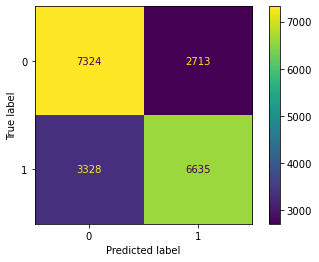

In [24]:
plot_confusion_matrix(model3_1a, X_test_3_1, y_test3);

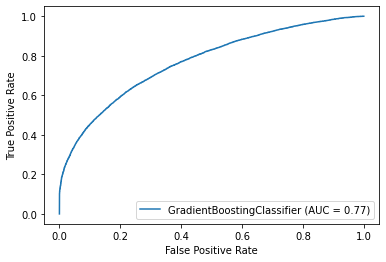

In [25]:
plot_roc_curve(model3_1a, X_test_3_1, y_test3)

One final check on hyper-parameters of the Logistic Regression model

In [24]:
logreg3_4 = LogisticRegression(penalty='l2', C=0.1, max_iter=1000)

logreg3_4.fit(X_3_1, y_train3)
y_pred3_4 = logreg3_4.predict_proba(X_test_3_1)[:, 1]
roc_auc3_4 = roc_auc_score(y_test3, y_pred3_4)
print("ROC AUC Score:", roc_auc3_4)

ROC AUC Score: 0.6356798969942059


## Running entire dataset on entire training data, and predicting on holdout

NOTE: while the full dataset was run below, due to memory and time constraints, the models were run using only the review text data, and not additional attributes. this resulted in a lower score, and will be re-run once time resources are freed up.

In [11]:
proc_stem_full = TextPreprocessorSTEM()
#create dataframes with Stemmed data
X_train_stem_full = proc_stem_full.fit_transform(X['text'])
test_stem_full = proc_stem_full.transform(X_test['text'])

KeyboardInterrupt: 

In [30]:
X_train_stem_full

1466627    place amaz roast bone marrow mac chees unexpec...
725299     decent lunch standard breakfast way go smoke s...
703075     felt much desir littl colleg restaur concept g...
1946293    figur time tread maoz sinc basic across street...
1205881    one best spas northsid indi person servic prov...
                                 ...                        
1303570    cosi rock conveni usual get pretti quick even ...
2257722    last year host parti restaur everyth fine exce...
1639564    enough room tell wonder tamira restaur cater h...
1322170    french cuisin favorit restaur nice nice worri ...
189213     facial microdermabras massag assuag better eve...
Name: text, Length: 1918473, dtype: object

In [20]:
X_train_stem_full.to_csv('X_train_stem_full.csv')
test_stem_full.to_csv('test_stem_full.csv')

In [12]:
X_train_stem_full = pd.read_csv('../X_train_stem_full.csv')
test_stem_full = pd.read_csv('../test_stem_full.csv')

X_train_stem_full.set_index("Unnamed: 0", inplace=True)
#X_train_stem_full.drop(columns=["Unnamed: 0"], inplace=True)

test_stem_full.set_index("Unnamed: 0", inplace=True)
#test_stem_full.drop(columns=["Unnamed: 0"], inplace=True)

In [13]:
X_train_stem_full['text'].fillna('', inplace=True)
test_stem_full['text'].fillna('', inplace=True)

In [18]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer_full1 = HashingVectorizer(n_features=3000)
X_full1 = vectorizer_full1.fit_transform(X_train_stem_full['text'])

X_test_full1 =  vectorizer_full1.transform(test_stem_full['text'])

In [19]:
X_full1.shape

(1918473, 3000)

In [22]:
X.shape

(1918473, 5)

In [23]:
#concatenating the non-text columns to the dataset - train data
X_full1 = pd.DataFrame.sparse.from_spmatrix(X_full1)
X_full1 = pd.concat([X[other_cols].reset_index(drop=True), X_full1], axis=1)
X_full1 = csr_matrix(X_full1.values)

#concatenating the non-text columns to the dataset - test data
X_test_full1 = pd.DataFrame.sparse.from_spmatrix(X_test_full1)
X_test_full1 = pd.concat([X_test[other_cols].reset_index(drop=True), X_test_full1], axis=1)
X_test_full1 = csr_matrix(X_test_full1.values)

MemoryError: Unable to allocate 42.9 GiB for an array with shape (3003, 1918473) and data type float64

In [ ]:
X_full1.shape

In [33]:
GB_clf_full = GradientBoostingClassifier(max_depth=10, n_estimators=100, random_state=53, verbose=2) 

In [34]:
GB_clf_full.fit(X_full1, y)

GB_y_pred_full = GB_clf_full.predict(X_test_full1)
GB_roc_auc_full = roc_auc_score(y_test, GB_y_pred_full)
print("ROC AUC Score:", GB_roc_auc_full)

      Iter       Train Loss   Remaining Time 
         1           1.3796          670.00m
         2           1.3739          670.42m
         3           1.3691          647.86m
         4           1.3648          641.56m
         5           1.3611          631.98m
         6           1.3578          624.33m
         7           1.3546          625.89m
         8           1.3519          620.08m
         9           1.3491          619.80m
        10           1.3468          607.21m
        11           1.3444          604.66m
        12           1.3424          591.75m
        13           1.3403          583.91m
        14           1.3384          575.82m
        15           1.3366          564.93m
        16           1.3349          551.38m
        17           1.3333          539.35m
        18           1.3318          528.52m
        19           1.3303          515.74m
        20           1.3289          503.47m
        21           1.3275          492.47m
        2

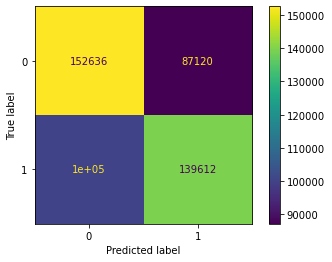

In [36]:
plot_confusion_matrix(GB_clf_full, X_test_full1, y_test);

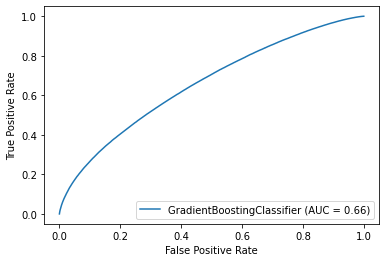

In [37]:
plot_roc_curve(GB_clf_full, X_test_full1, y_test)

In [35]:
import joblib

joblib.dump(GB_clf_full, 'GB_model_full_yelp.pkl')

['GB_model_full_yelp.pkl']

### NOTE: below cells are archive cells of models tested, keeping for future reference but setting as non-executable.